#**Homework 2 - Website Fingerprinting - K-NN Implementation & Evaluation**

## **Objective**
The homework required the implementation of a website fingerprinting approach able to classify the websites visited by a user by observing only the encrypted HTTPS traffic.

More in detail, it was asked to:
1.   **Create a dataset**: this should have been done by visiting 10 times 10
among the most popular news websites that do not require login. For each visit performed, packets exchanged between the requesting machine and the server should have been captured in a separate .pcap file

2.   **Extract Features**: 2 alternative methods were proposed to extract features from each capture collected:
    - (*Mandatory*) Extract biflow statistical feautures (both uplink and dowlink):
      - Number of packets up/down
      - Total bytes up/down
      - Min/max/mean/std of the packet size up/down
      - Min/max/mean/std IAT (Inter Arrival Time) up/down

    - (*Optional*) Extract the Cumulative Trace of packets exchanged, ignoring TCP ACKs, and sample its piecewise linear interpolant at 20 equidistant points. This method is based on an a approach proposed in the literature (Reference: *A. Panchenko et al. “Website Fingerprinting at Internet Scale NDSS 2016*)

3.   **Evaluate the performance of a K-NN approach**: the accuracy obtained by a K-NN classifier with values of K going from 1 to 10 should have been plotted on an Accuracy/K graph

The construction of the **training and test sets** for the predictive algorithm should have been performed in 2 different ways:
1.   At first, the data gathered on a particulare day should have been split in a training set (70%) and a test set (30%)

2.   Then, after some time (e.g. 1 day), an additional test set should have been built, by visiting the same 10 websites 3 times each. Subsequently, the performance obtained using the old training set and the newly created test set should have been compared with the approach using the old training and test sets.

---

This notebook covers the implementation of a K-NN algorithm for a website fingerprinting task. The algorithm is evaluated in 4 differente scenarios:
1.   With a dataset of 100 samples, generated on 23rd March 2024, representing the biflow statistical features of 100 different traffic captures, divided in training (70%) and test set (30%)
2.   With the training set from 23rd March 2024 and a test set of 30 samples gathered the day after (24th March 2024), both representing biflow statistical features
3.   With a dataset of 100 samples, generated on 23rd March 2024, representing the cumulative trace features of 100 different traffic captures, divided in training (70%) and test set (30%)
4.    With the training set from 23rd March 2024 and a test set of 30 samples gathered the day after (24th March 2024), both representing cumulative trace features

# Import Libraries

In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [152]:
path = "/content/drive/MyDrive/[NM-LAB]/Homework2/"

# K-NN Utilities

This section contains utility functions used for the implementation of the K-NN algorithm and its performance evaluation. These functions will be invoked in the following sections with different parameters, depending on the specific scenario.

`K` represents the maximum number of neighbours the algorithm will consider and we set it to be euqal to `10`. Then, the K-NN procedure will be invoked with every value of `k` from `k = 1` to `k = K = 10` and the performance between all these cases will be compared.

In [154]:
K = 10

The KNN procedure is the direct implementation of the K-NN algorithm and it is parametric with resepct to prameter K. The function takes every sample in the test set and for each of them it builds the vector of Euclidean distances of the same data point from all the samples in the training set.

Then, it takes the most frequent label among the labels in the set of the k closest data points in the training set (the k nearest neighbours). The selected label is the prediction given as output for the given test set sample.

The procedure also keeps track of the accuracy over the test set and gives it as output together with the predictions produced for every sample in the test set.

In [155]:
def KNN(x_train,x_test,y_train,y_test,K):
  test_predictions = []
  accuracy = 0
  i = 0

  # Iterate over the samples inside the training set
  for test_idx, test_row in x_test.iterrows():
    distances = []

    # Compute the distance between each row in the test set and all the rows in the training set
    for train_idx, train_row in x_train.iterrows():
      dist = np.linalg.norm(np.array(test_row.to_numpy() - train_row.to_numpy()))
      distances.append(dist)

    # Implement majority voting
    sorted_idx = np.argsort(distances)
    prediction = y_train.iloc[sorted_idx[:K]].mode()[0]
    test_predictions.append(prediction)

    # Update the overall accuracy
    if (prediction == y_test.iloc[i]):
      accuracy += 1

    i += 1

  return accuracy/len(y_test), test_predictions

This function invokes the KNN procedure for each value of k in the admissible range (1 to 10) and for each of this cases it builds the corresponding confusion matrix, displaying it as output. It also returns the list of accuracies obtained for each of the K experiemnts.

In [156]:
def make_predictions(x_norm_train,x_norm_test,y_train,y_test,K):
  accuracy_list = []

  # Set the number of columns in the grid layout
  num_columns = 5

  # Calculate the number of rows needed to accommodate all K values
  num_rows = (K + num_columns - 1) // num_columns

  # Set the figure size based on the number of rows and columns
  fig_width = 8 * num_columns
  fig_height = 8 * num_rows

  # Create a figure with the adjusted size
  fig, axes = plt.subplots(num_rows, num_columns,figsize=(fig_width,fig_height))

  # Iterate over values of k from 1 to K
  for k in range(1,K+1):
    # Compute the accuracy and retrieve the predictions
    accuracy, predictions = KNN(x_norm_train,x_norm_test,y_train,y_test,k)
    accuracy_list.append(accuracy)
    # Set up the confusion matrix
    cm = confusion_matrix(y_test, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_test.unique())
    row_index = (k - 1) // num_columns
    col_index = (k - 1) % num_columns
    # Plot confusion matrix
    disp.plot(ax=axes[row_index, col_index])
    axes[row_index, col_index].set_title(f'Confusion Matrix for K={k}', fontsize=20)
    axes[row_index, col_index].set_xticklabels(axes[row_index, col_index].get_xticklabels(), rotation=90, fontsize=17)
    axes[row_index, col_index].set_yticklabels(axes[row_index, col_index].get_yticklabels(), rotation=0, fontsize=17)

  # Adjust layout
  plt.tight_layout()

  return accuracy_list

This is a utility function that prints a Accuracy Vs. K graph for the accuracy list given as input and for the given range of admissible K's.

In [157]:
def print_accuracy_per_k(accuracy_list,K):
  fig = plt.figure()
  plt.plot(np.arange(1,K+1,1),accuracy_list)
  plt.plot(np.argmax(accuracy_list) + 1, max(accuracy_list), '^b')  # Plot the maximum accuracy point
  plt.plot(np.argmin(accuracy_list) + 1, min(accuracy_list), 'ob')  # Plot the minimum accuracy point
  plt.xticks(np.arange(1,K+1,1))
  plt.legend(["Accuracy", "Max Accuracy", "Min Accuracy"])
  plt.title("Accuracy Vs. K Graph")
  plt.xlabel("K")
  plt.ylabel("Accuracy")
  plt.grid(True)

# Website Fingerprinting with Biflow Statistical Features

## Version 1: Single Dataset

Here we discuss about the results obtained with a dataset of 100 samples, generated on 23rd March 2024, representing the biflow statistical features of 100 different traffic captures, divided in training (70%) and test set (30%)

### Load Dataset

For this first version, we use data gathered on 23rd March 2024 and we laod it from the corresponding CSV file.

In [158]:
# Upload the dataset from CSV
df = pd.read_csv(path+"dataset_2024-03-23.csv")
# Drop the 'Unnamed: 0' column
df.drop(columns=['Unnamed: 0'], inplace=True)

display(df)

,num_pkts_uplink,num_pkts_downlink,total_bytes_uplink,min_pkt_size_uplink,max_pkt_size_uplink,mean_pkt_size_uplink,std_pkt_size_uplink,total_bytes_downlink,min_pkt_size_downlink,max_pkt_size_downlink,...,std_pkt_size_downlink,min_iat_uplink,max_iat_uplink,mean_iat_uplink,std_iat_uplink,min_iat_downlink,max_iat_downlink,mean_iat_downlink,std_iat_downlink,website
0,66,65,4231.0,40.0,569.0,64.106061,64.832121,573013.0,52.0,39040.0,...,9369.559465,0.000006,0.089473,0.002579,0.011001,0.000001,0.091960,0.002573,0.011400,www.bbc.co.uk
1,46,47,3191.0,40.0,569.0,69.369565,77.316481,579635.0,52.0,39040.0,...,12472.990530,0.000006,0.056596,0.002640,0.008413,0.000000,0.058164,0.002539,0.008553,www.bbc.co.uk
2,43,44,3035.0,40.0,569.0,70.581395,79.886000,571631.0,52.0,56368.0,...,15659.430595,0.000004,0.055132,0.002589,0.008472,0.000001,0.056333,0.002485,0.008564,www.bbc.co.uk
3,51,52,3451.0,40.0,569.0,67.666667,73.534119,571910.0,52.0,56368.0,...,13955.549997,0.000006,0.054587,0.002246,0.007668,0.000001,0.057237,0.002140,0.007947,www.bbc.co.uk
4,46,45,3191.0,40.0,569.0,69.369565,77.316481,571522.0,52.0,47704.0,...,13857.039449,0.000006,0.058279,0.003034,0.008924,0.000000,0.059685,0.003061,0.009172,www.bbc.co.uk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,12,9,1457.0,52.0,569.0,121.416667,143.691879,5150.0,52.0,2948.0,...,958.981462,0.000005,0.058028,0.007913,0.017541,0.000001,0.059728,0.016066,0.023273,www.washingtonpost.com
96,12,9,1457.0,52.0,569.0,121.416667,143.691879,5150.0,52.0,2948.0,...,958.981462,0.000007,0.066319,0.008199,0.019619,0.000002,0.068592,0.016289,0.025644,www.washingtonpost.com
97,12,9,1457.0,52.0,569.0,121.416667,143.691879,5150.0,52.0,2948.0,...,958.981462,0.000007,0.054767,0.007398,0.016420,0.000002,0.056310,0.015351,0.022257,www.washingtonpost.com
98,12,9,1457.0,52.0,569.0,121.416667,143.691879,5150.0,52.0,2948.0,...,958.981462,0.000006,0.059687,0.007535,0.017742,0.000001,0.061293,0.015366,0.023457,www.washingtonpost.com


### Pre-processing

Before invoking the KNN procedure, we split the dataset in training (70%) and test set (30%). Additionally, we make sure that in the training set we have at least one sample for each of the 10 classes (websites). In case the random split process couldn't satisfy this requirement, we repeat it until it satisfaction.

We also process data by standardizing it, i.e. we remove the mean value from each element in a column and we divide by the standard deviation computed over the entire column itself.

In [159]:
# Extact the labels vector
y = df["website"]
# Remove labels from features
x = df.drop(['website'],axis=1)

# Define indexes for the split between train and test set
idx = np.random.permutation(len(x))
num_train_samples = int(np.floor(0.7 * len(df)))
train_idx = idx[:num_train_samples]
test_idx = idx[num_train_samples:]

# Split the label vector between the train and test portions
y_train = y.iloc[train_idx]
y_test = y.iloc[test_idx]

# Make sure test set contains samples from all classes
while len(np.unique(y_test)) != len(np.unique(y_train)):
  idx = np.random.permutation(len(x))
  num_train_samples = int(np.floor(0.7 * len(df)))

  train_idx = idx[:num_train_samples]
  test_idx = idx[num_train_samples:]

  y_train = y.iloc[train_idx]
  y_test = y.iloc[test_idx]

# Standardization
x_norm = pd.DataFrame()

# Iterate over each column of the df
for key in x: # key is the column name
  temp = x[key] # Select an entire column of the df
  temp_norm = (temp - temp.mean()) / temp.std()
  x_norm[key] = temp_norm

# Split in train and test sets
x_norm_train = x_norm.iloc[train_idx]
x_norm_test = x_norm.iloc[test_idx]

### Make Predictions

We feed the pre-processed data to the procedure that perfroms K-NN classification, returning the accuracy list for different values of k and displaying the confusion matrices for each k.

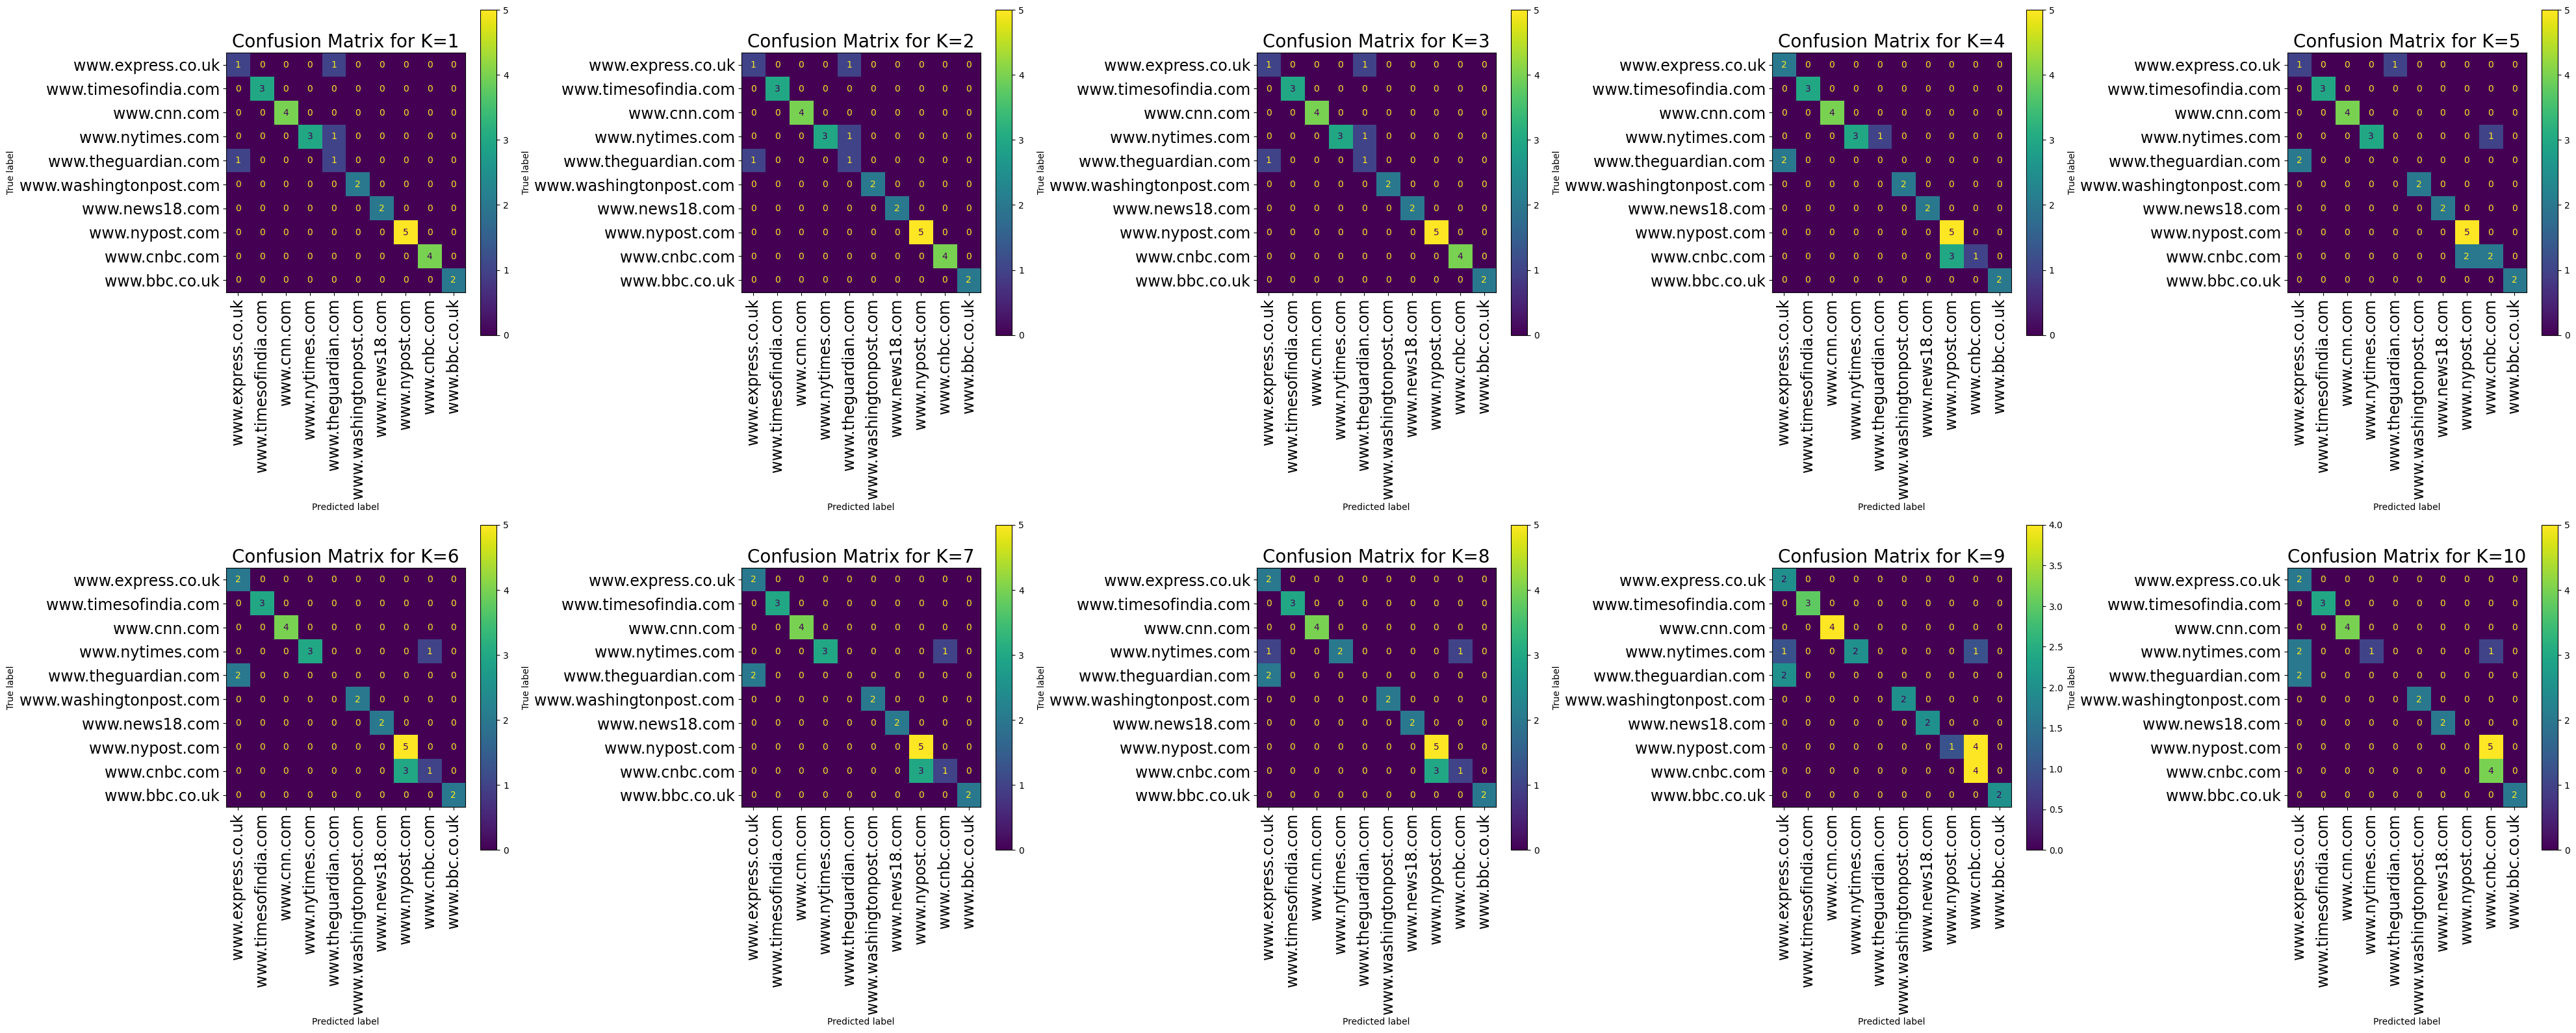

In [160]:
accuracy_list = make_predictions(x_norm_train,x_norm_test,y_train,y_test,K)

### Evaluate Performance

We inspect the accuracy results for varying value of the k parameter.

In [161]:
for k,accuracy in enumerate(accuracy_list):
  print(f"Accuracy (K = {k+1}): {accuracy}")

Accuracy (K = 1): 0.9
Accuracy (K = 2): 0.9
Accuracy (K = 3): 0.9
Accuracy (K = 4): 0.8
Accuracy (K = 5): 0.8
Accuracy (K = 6): 0.8
Accuracy (K = 7): 0.8
Accuracy (K = 8): 0.7666666666666667
Accuracy (K = 9): 0.7333333333333333
Accuracy (K = 10): 0.6666666666666666


We also print the Accuracy Vs. K Graph.

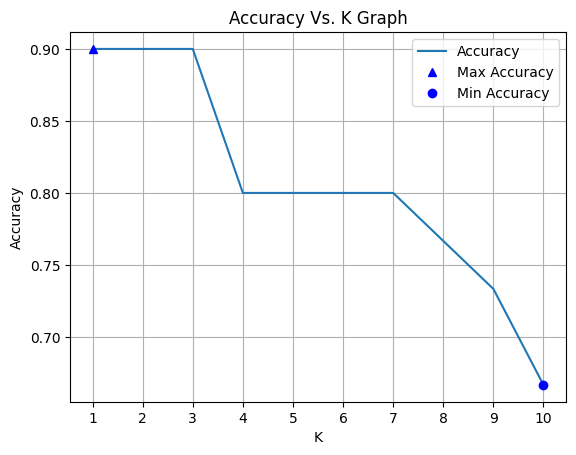

In [162]:
print_accuracy_per_k(accuracy_list,K)

The graph shows that the best accuracy is the one obtained with K = 1 and the worse one corresponds to K = 10. More in general the accuracy shows a non-increasing behaviour as the value of K grows.

## Version 2: External Test Set

We now focus on a different scenario were we evaluate the perforance of the K-NN algorithm when using the training set of the 23rd March 2024 and, as test set, the dataset with just 30 data points collected on the following day.

### Load External Test Set

We load the external test set collected on 24th March 2023.

In [163]:
# Load the test set from CSV
df_test = pd.read_csv(path+"testset_2024-03-24.csv")
# Drop the 'Unnamed: 0' column
df_test.drop(columns=['Unnamed: 0'], inplace=True)

display(df_test)

,num_pkts_uplink,num_pkts_downlink,total_bytes_uplink,min_pkt_size_uplink,max_pkt_size_uplink,mean_pkt_size_uplink,std_pkt_size_uplink,total_bytes_downlink,min_pkt_size_downlink,max_pkt_size_downlink,...,std_pkt_size_downlink,min_iat_uplink,max_iat_uplink,mean_iat_uplink,std_iat_uplink,min_iat_downlink,max_iat_downlink,mean_iat_downlink,std_iat_downlink,website
0,93,95,5635.0,40.0,569.0,60.591398,54.773890,557316.0,52.0,17380.0,...,4729.443591,0.000007,0.057974,0.002120,0.006467,0.000001,0.069372,0.001949,0.007332,www.bbc.co.uk
1,90,90,5479.0,40.0,569.0,60.877778,55.666307,557031.0,52.0,17380.0,...,4931.161711,0.000007,0.056996,0.001990,0.006308,0.000000,0.067871,0.001862,0.007299,www.bbc.co.uk
2,107,110,6363.0,40.0,569.0,59.467290,51.111664,558073.0,52.0,11604.0,...,3572.771445,0.000004,0.066857,0.001945,0.006753,0.000000,0.077736,0.001786,0.007527,www.bbc.co.uk
3,144,154,8302.0,40.0,569.0,57.652778,44.286309,2077535.0,52.0,56524.0,...,16000.939031,0.000004,0.060000,0.001359,0.005272,0.000001,0.070721,0.001197,0.005886,www.cnbc.com
4,141,141,8146.0,40.0,569.0,57.773050,44.750478,2076858.0,52.0,56524.0,...,17580.781443,0.000003,0.056624,0.001432,0.005069,0.000001,0.067403,0.001351,0.005834,www.cnbc.com
5,134,135,7782.0,40.0,569.0,58.074627,45.892917,2076546.0,52.0,56524.0,...,17751.419511,0.000005,0.054687,0.001414,0.005070,0.000001,0.065539,0.001320,0.005840,www.cnbc.com
6,326,327,17750.0,40.0,569.0,54.447853,29.394223,2647871.0,52.0,18824.0,...,4838.180029,0.000006,0.055341,0.001241,0.003299,0.000001,0.066204,0.001202,0.003762,www.cnn.com
7,324,333,17646.0,40.0,569.0,54.462963,29.484453,2648189.0,52.0,18824.0,...,4881.104849,0.000006,0.056676,0.001184,0.003366,0.000001,0.067693,0.001117,0.003814,www.cnn.com
8,308,309,16814.0,40.0,569.0,54.590909,30.237521,2646942.0,52.0,18824.0,...,4803.758324,0.000007,0.054609,0.001308,0.003382,0.000001,0.065347,0.001267,0.003822,www.cnn.com
9,54,53,3646.0,52.0,569.0,67.518519,71.350779,449791.0,52.0,24328.0,...,7271.496508,0.000012,0.402863,0.011168,0.055706,0.000001,0.350428,0.011170,0.049689,www.express.co.uk


### Pre-processing with External Test Set

Before proceeding with the K-NN classification step, we also standardize the test data (the training data is already standardized from the previous experiment).

In [164]:
# Extact the labels vector
y_test = df_test["website"]
# Remove labels from features
x_test = df_test.drop(['website'],axis=1)

# Standardization
x_norm_test = pd.DataFrame()

# Iterate over each column of the df
for key in x_test: # key is the column name
  temp = x_test[key] # selecting an entire column of the df
  temp_norm = (temp - temp.mean()) / temp.std()
  x_norm_test[key] = temp_norm

### Make Predictions with External Test Set

We now give as input to the `make_prediction` procedure the old training set and newly created test set. In this way, the K-NN procedure will be invoked for every K in the range [1,10] and we will get the accuracy list for all of them.

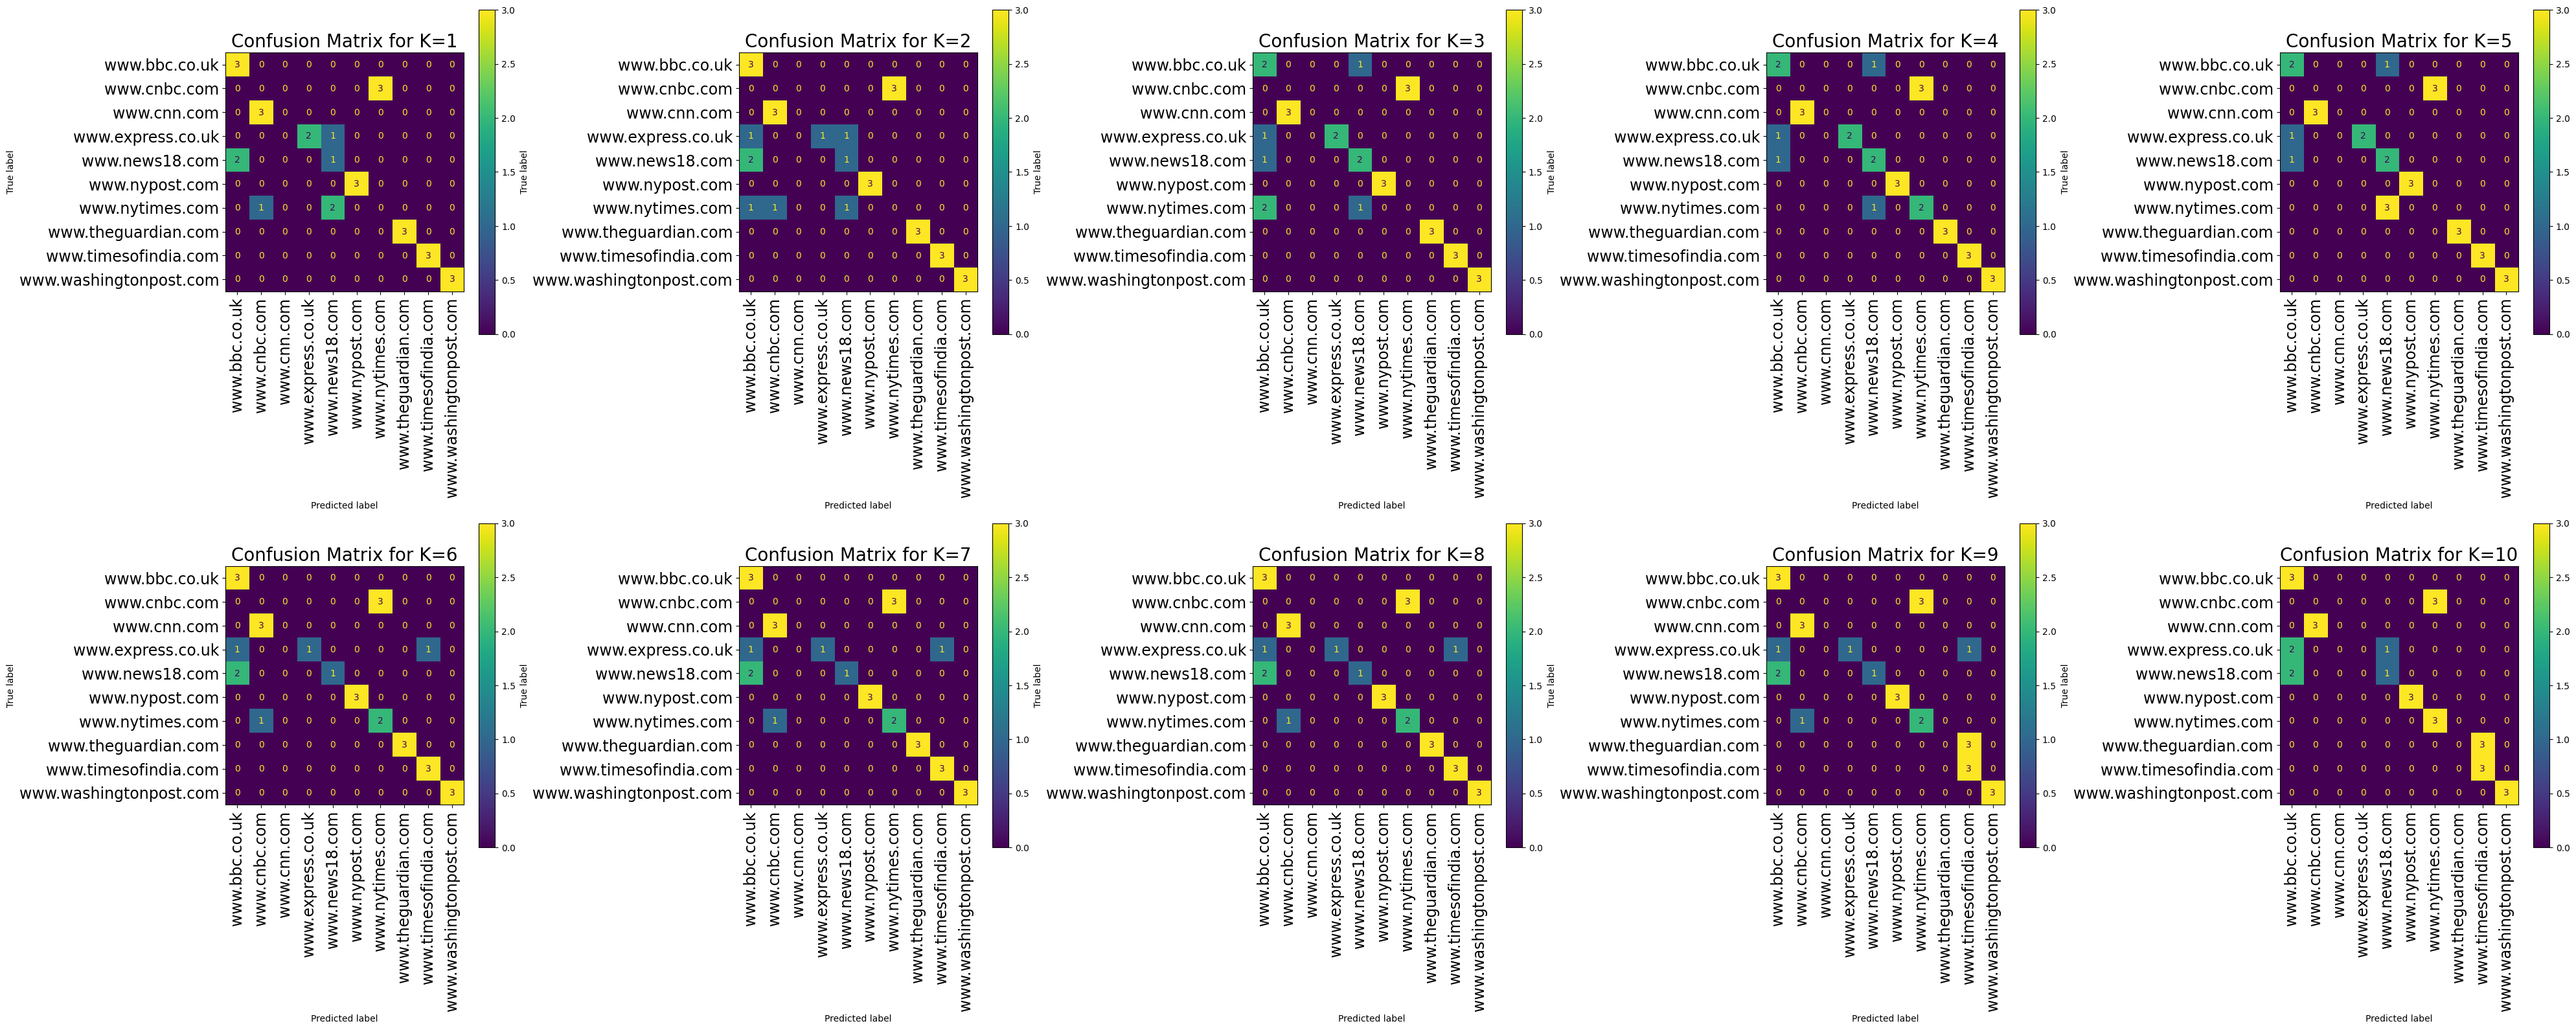

In [165]:
accuracy_list_no_split = make_predictions(x_norm_train,x_norm_test,y_train,y_test,K)

### Evaluate Performance with External Test Set

We can know inspect the accuracy result for every value of K.

In [166]:
for k,accuracy in enumerate(accuracy_list_no_split):
  print(f"Accuracy (K = {k+1}): {accuracy}")

Accuracy (K = 1): 0.6
Accuracy (K = 2): 0.5666666666666667
Accuracy (K = 3): 0.6
Accuracy (K = 4): 0.6666666666666666
Accuracy (K = 5): 0.6
Accuracy (K = 6): 0.6333333333333333
Accuracy (K = 7): 0.6333333333333333
Accuracy (K = 8): 0.6333333333333333
Accuracy (K = 9): 0.5333333333333333
Accuracy (K = 10): 0.5333333333333333


We also plot the accuracy over an Accuracy Vs. K graph.

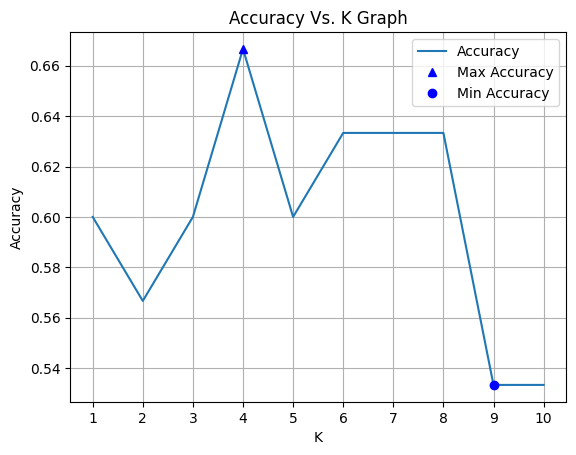

In [167]:
print_accuracy_per_k(accuracy_list_no_split,K)

The plot shows that the highest accuracy is achieved with K = 4 and the worst performance is the one obtained with K = 9,10

## Compare Performances

We now compare the performance of website fingerptinting with Biflow Statistical Fatures using the 2 different test sets.

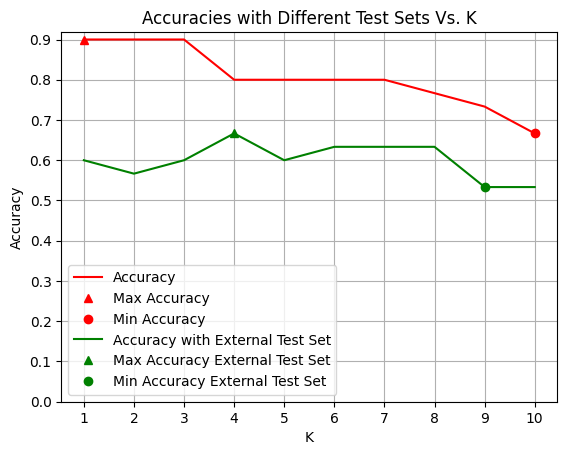

In [168]:
fig = plt.figure()

plt.plot(np.arange(1,K+1,1),accuracy_list,'r')
plt.plot(np.argmax(accuracy_list) + 1, max(accuracy_list), '^r')  # Plot the maximum accuracy point
plt.plot(np.argmin(accuracy_list) + 1, min(accuracy_list), 'or')  # Plot the minimum accuracy point

plt.plot(np.arange(1,K+1,1),accuracy_list_no_split,'g')
plt.plot(np.argmax(accuracy_list_no_split) + 1, max(accuracy_list_no_split), '^g')  # Plot the maximum accuracy point
plt.plot(np.argmin(accuracy_list_no_split) + 1, min(accuracy_list_no_split), 'og')  # Plot the minimum accuracy point

plt.xticks(np.arange(1,K+1,1))
plt.yticks(np.arange(0.0,1.0,0.1))

plt.legend(["Accuracy", "Max Accuracy", "Min Accuracy","Accuracy with External Test Set", "Max Accuracy External Test Set", "Min Accuracy External Test Set"])
plt.title("Accuracies with Different Test Sets Vs. K")
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.grid(True)

From the plot we can see that the best overall performance is achieved by the first version of the algorithm, i.e. the one using a single dataset which is split between training and test sets, which completely dominates the second version using an external test set, for all values of K.

This observation aligns with the initial expections. Indeed, it seems reasonable that the accuracy is higher when the test set was collected on the same day and around at the same time with respect to the training set. This is because the corresponding traffic captures were done under the same network conditions (same conjestion level, same latencies, etc.) and the content of website home page to be transferred from server to client was the same, thus leading to a better perfomance when trying to predcit the website a user visited, by looking at the encrypted HTTPS traffic exchanged with server hosting the website.

By comparing the models' performance for increasing values of K, we might also observe that, while in the in the first case (red plot) the best performance is achieved for K = 1 (but also for K = 2,3), in the second case (green plot) the best accuracy is the one corresponding to K = 4 and the accuracy for lower values of K is not as high. This can be explained by the fact that when traing and test sets show similar distributions, looking at just one neighbour might be enough to make accurate predictions. Whereas, when the test set distribution changes with respect to that of the trainin data, considering just a single neighbour might lead to underfitting. Therfore, taking into account more neghbours can be more effective when trying to achieve a higher model performance.

We can finally make some considerations on the values of K which yield the worst performance in both scenarios. In both cases, starting from K = 5 the accuracy gradually drops, achieving the worst performance when approaching the highest values of K. This trend aligns with the expectations according to which the more neighbours are taken into account, the more likely is to let distant and distant neighbours influence the final predictions, potentially introducing noise and leading to inaccurate results.

In the end, the selection of an appropriate value of K is a matter of striking a balance between high variance, generally achieved with K = 1, and high bias, determined by high values of K. Indeed, we don't want our model to be neither extremely senstitive to a single data point (K = 1) nor to generalize too much, due to the influence of more distant data points (higher K).

# Website Fingerprinting with Cumulative Traces

We now discuss about the results obtained with a dataset of 100 samples, generated on 23rd March 2024, representing the Cumulative Trace sampled at 20 equidistant points related to 100 different traffic captures, divided in training (70%) and test set (30%)

## Version 1: Single Dataset

### Load Dataset

For this version we use data gathered on 23rd March 2024 and we load it from the corresponding CSV file.

In [169]:
# Upload the datatset from CSV
trace_df = pd.read_csv(path+"trace_dataset_2024-03-23.csv")
# Drop the 'Unnamed: 0' column
trace_df.drop(columns=['Unnamed: 0'], inplace=True)

display(trace_df)

,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,T12,T13,T14,T15,T16,T17,T18,T19,Website
0,899.000000,1539.157895,2313.947368,6372.578947,14195.473684,23561.000000,31755.263158,45354.157895,59816.000000,75731.000000,93916.842105,102119.736842,133418.000000,173867.526316,202438.421053,246509.000000,276375.157895,272229.157895,263264.0,www.bbc.co.uk
1,-193.842105,1810.000000,1444.473684,1896.315789,2385.052632,18114.947368,32989.105263,38700.105263,59198.052632,96716.947368,121926.894737,134615.157895,145859.421053,180198.526316,242113.421053,290466.052632,273857.315789,235230.263158,196579.0,www.bbc.co.uk
2,-48.789474,2490.000000,2127.526316,1783.210526,1594.736842,1453.947368,19601.105263,37872.368421,49038.157895,70217.842105,100745.526316,118657.210526,165223.842105,179572.368421,203420.894737,198792.789474,190325.105263,181879.526316,173371.0,www.bbc.co.uk
3,-375.157895,1779.473684,2625.526316,1953.157895,2386.473684,11260.105263,18420.105263,26413.473684,39483.157895,50723.578947,69254.736842,87314.210526,106359.052632,157418.210526,181277.263158,190745.263158,260450.526316,248842.631579,179130.0,www.bbc.co.uk
4,-48.789474,2490.000000,2127.526316,1783.210526,1597.105263,15921.210526,28081.894737,38415.526316,55738.842105,67970.157895,93653.473684,120704.789474,131380.631579,171701.526316,212732.578947,227228.842105,225244.473684,223282.210526,221257.0,www.bbc.co.uk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-47.368421,9.473684,-193.842105,-54.736842,2816.578947,1185.789474,1767.105263,2105.789474,683.105263,2528.894737,1115.789474,1442.315789,2138.368421,810.368421,2630.894737,1609.947368,1760.315789,2581.368421,719.0,www.washingtonpost.com
96,-47.368421,9.473684,-193.842105,-54.736842,2816.578947,1185.789474,1767.105263,2105.789474,683.105263,2528.894737,1115.789474,1442.315789,2138.368421,810.368421,2630.894737,1609.947368,1760.315789,2581.368421,719.0,www.washingtonpost.com
97,-47.368421,9.473684,-193.842105,-54.736842,2816.578947,1185.789474,1767.105263,2105.789474,683.105263,2528.894737,1115.789474,1442.315789,2138.368421,810.368421,2630.894737,1609.947368,1760.315789,2581.368421,719.0,www.washingtonpost.com
98,-47.368421,9.473684,-193.842105,-54.736842,2816.578947,1185.789474,1767.105263,2105.789474,683.105263,2528.894737,1115.789474,1442.315789,2138.368421,810.368421,2630.894737,1609.947368,1760.315789,2581.368421,719.0,www.washingtonpost.com


### Pre-processing

Before invoking the KNN procedure, we split the dataset in training (70%) and test set (30%). Additionally, we make sure that in the training set we have at least one sample for each of the 10 classes (websites). In case the random split process couldn't satisfy this requirement, we repeat it until it is satiasfied.

In [170]:
# Extract the labels vector
y = trace_df["Website"]
# Remove labels from from features
x = trace_df.drop(["Website"],axis=1)

# Define indexes for the split between train and test set
idx = np.random.permutation(len(x))
num_train_samples = int(np.floor(0.7 * len(trace_df)))
train_idx = idx[:num_train_samples]
test_idx = idx[num_train_samples:]

# Split the label vector between the train and test portions
y_train = y.iloc[train_idx]
y_test = y.iloc[test_idx]

# Make sure the test set contains samples from all classes
while len(np.unique(y_test)) != len(np.unique(y_train)):
  idx = np.random.permutation(len(x))
  num_train_samples = int(np.floor(0.7 * len(trace_df)))

  train_idx = idx[:num_train_samples]
  test_idx = idx[num_train_samples:]

  y_train = y.iloc[train_idx]
  y_test = y.iloc[test_idx]

# Split dataset between train and test sets
x_train = x.iloc[train_idx]
x_test = x.iloc[test_idx]

### Make Predictions

We feed the pre-processed data to the procedure that performs the K-NN classification algorithm, which returns the accuracy list for different values of k and that also displays the confusion matrix for each k.

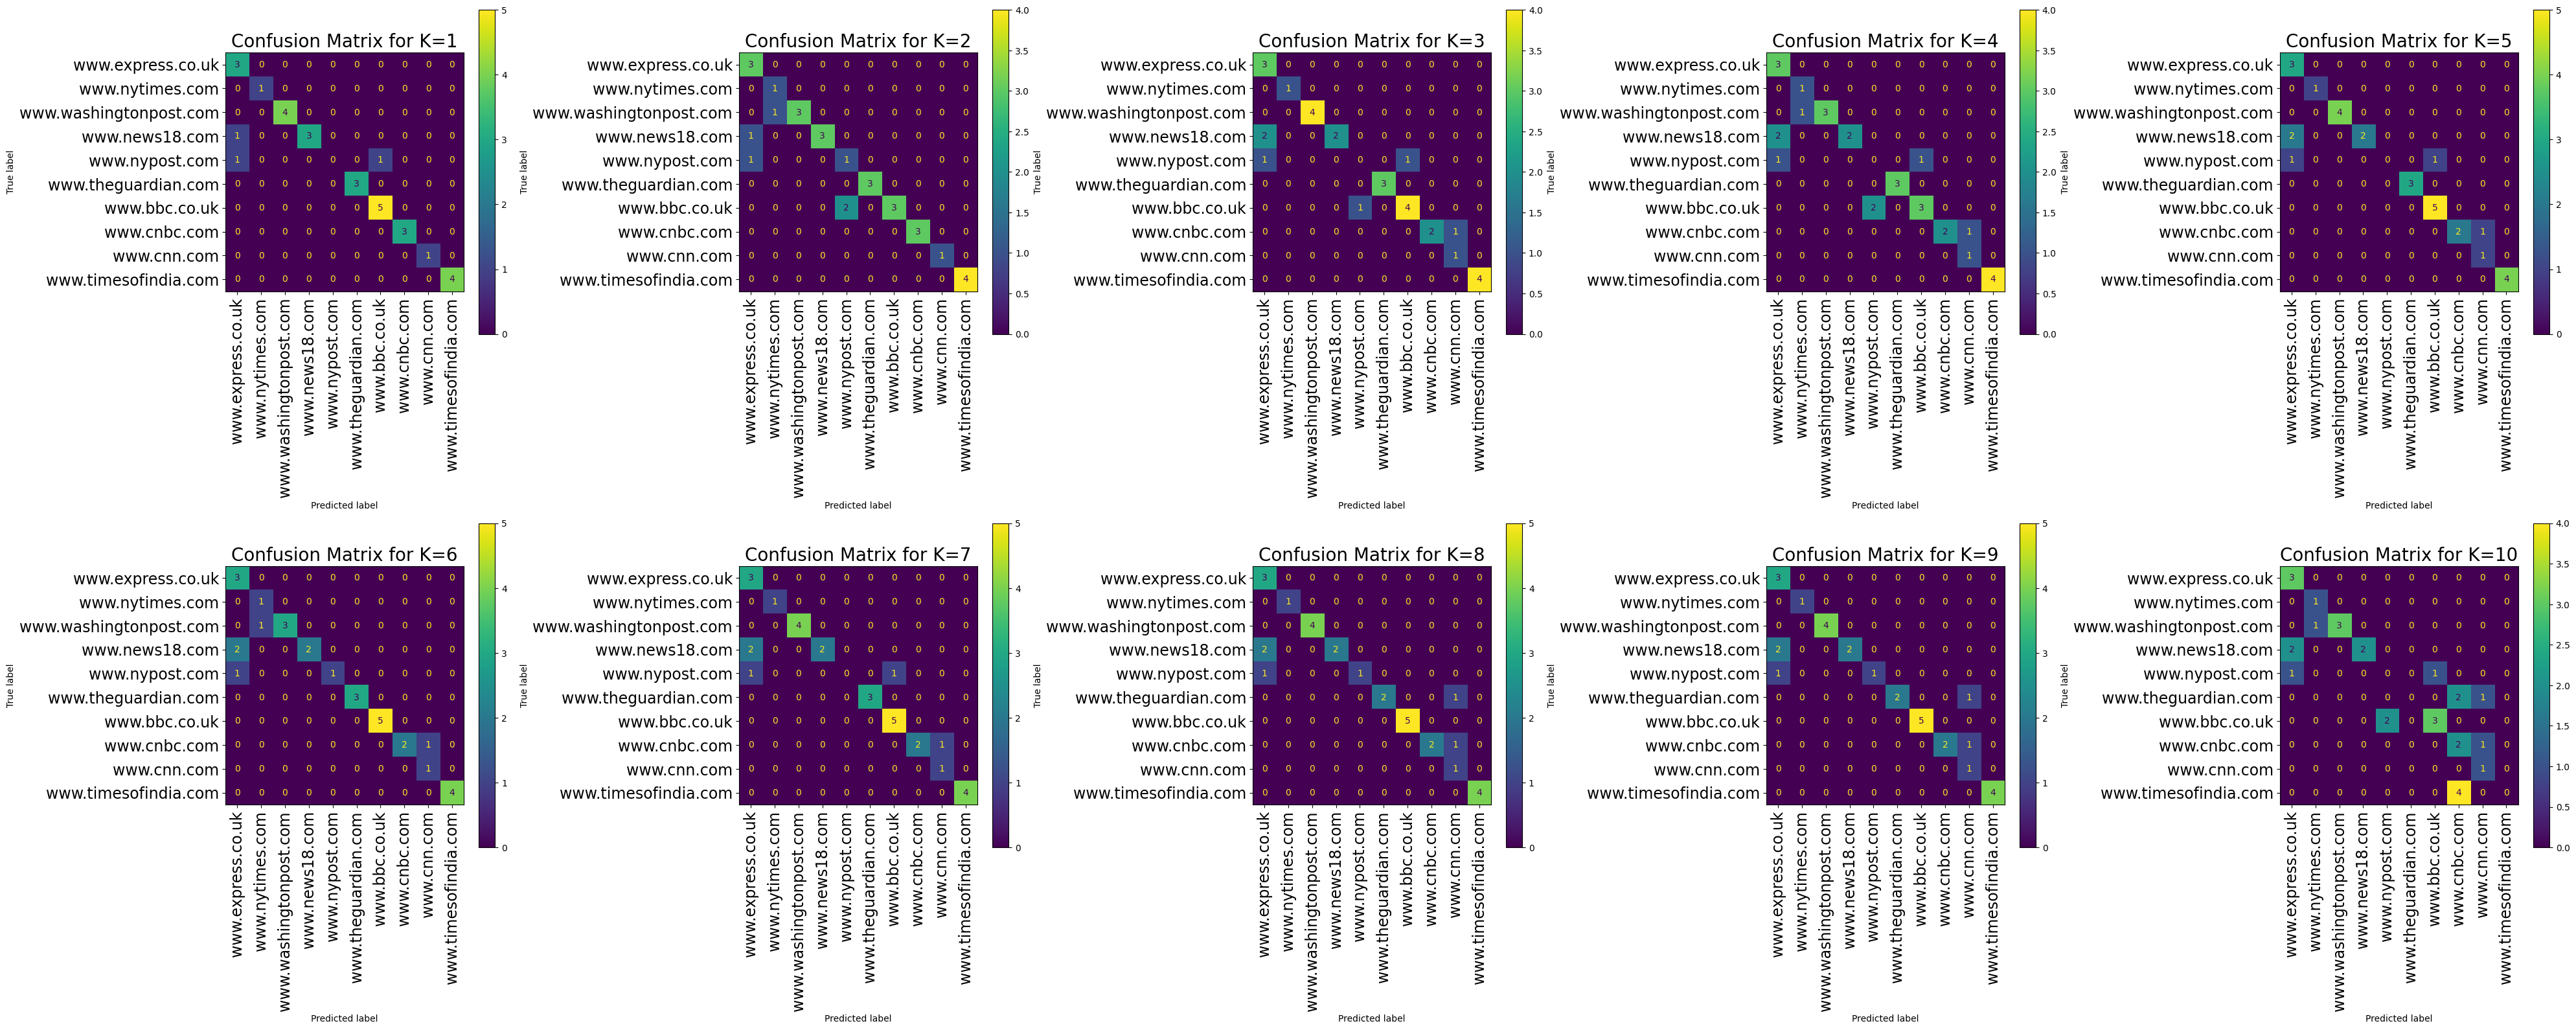

In [171]:
trace_accuracy_list = make_predictions(x_train,x_test,y_train,y_test,K)

### Evaluate Performance

We then inspect the accuracy value for eack k from 1 to 10.

In [172]:
for k,accuracy in enumerate(trace_accuracy_list):
  print(f"Accuracy (K = {k+1}): {accuracy}")

Accuracy (K = 1): 0.9
Accuracy (K = 2): 0.8333333333333334
Accuracy (K = 3): 0.8
Accuracy (K = 4): 0.7333333333333333
Accuracy (K = 5): 0.8333333333333334
Accuracy (K = 6): 0.8333333333333334
Accuracy (K = 7): 0.8333333333333334
Accuracy (K = 8): 0.8333333333333334
Accuracy (K = 9): 0.8333333333333334
Accuracy (K = 10): 0.5


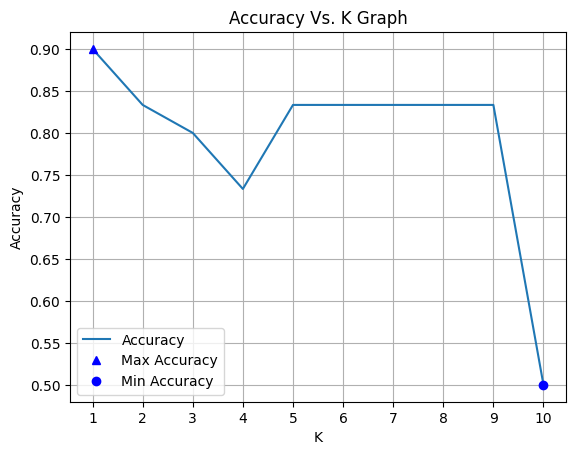

In [173]:
print_accuracy_per_k(trace_accuracy_list,K)

The plot shows how the best performance is achieved with K = 1. Then, between K = 9 and K = 10, the accuracy makes a significant drop-off, reaching the global minimum at K = 10.

## Version 2: External Test Set

We now focus on the evaluation of the performance of a K-NN classifier when using the training set of the 23rd March 2024 and as training set the dataset with just 30 data points collected on the following day.

Load External Test Set

As firt step we load the dataset to be used as test set from the corresponding CSV file.

In [174]:
# Load test set from CSV
trace_test_df = pd.read_csv(path+"trace_testset_2024-03-24.csv")
# Drop the 'Unnamed: 0' column
trace_test_df.drop(columns=['Unnamed: 0'], inplace=True)

display(trace_test_df)

,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,T12,T13,T14,T15,T16,T17,T18,T19,Website
0,1725.000000,2051.052632,5086.368421,9157.105263,19902.631579,23352.157895,31247.684211,41689.210526,52758.210526,77063.315789,99374.631579,122452.578947,144999.473684,171489.842105,193357.473684,228361.736842,2.528067e+05,2.593223e+05,265624.0,www.bbc.co.uk
1,2065.000000,1432.105263,5192.789474,10092.157895,17275.947368,22958.894737,32891.526316,43951.315789,56809.842105,75552.157895,97606.684211,128806.473684,148619.105263,172162.052632,198497.842105,228146.052632,2.604924e+05,2.685723e+05,264461.0,www.bbc.co.uk
2,1779.473684,1954.736842,8198.368421,15971.473684,22305.578947,30276.210526,37732.210526,48772.526316,63834.315789,80615.157895,104891.052632,125436.421053,149718.105263,176145.157895,189844.736842,225357.052632,2.413953e+05,2.522992e+05,264016.0,www.bbc.co.uk
3,1190.105263,737.947368,8538.421053,17696.789474,25656.736842,37907.736842,54894.842105,74057.736842,111555.368421,138765.736842,188457.052632,289393.842105,357594.421053,354374.684211,472629.684211,518320.052632,5.667675e+05,6.418335e+05,656493.0,www.cnbc.com
4,1803.157895,1032.421053,6495.473684,16576.631579,29325.157895,42576.000000,54546.000000,65220.421053,96213.578947,137845.894737,186977.157895,248636.421053,334302.000000,413627.368421,515694.631579,628507.578947,6.212881e+05,5.748659e+05,495697.0,www.cnbc.com
5,2569.473684,2439.263158,6422.526316,15223.368421,25548.421053,41741.684211,57858.736842,77252.842105,110822.105263,145510.210526,194971.578947,234269.578947,343505.684211,401122.473684,454385.526316,469728.368421,4.892628e+05,5.171342e+05,507635.0,www.cnbc.com
6,7410.578947,28280.315789,52751.473684,92282.631579,142501.789474,200852.947368,255100.105263,302331.263158,367082.421053,435177.578947,503728.736842,588883.894737,665627.052632,752402.210526,843889.368421,948704.526316,1.077524e+06,1.220175e+06,1309506.0,www.cnn.com
7,5645.000000,27604.000000,56965.000000,96252.000000,150161.000000,190892.000000,266461.000000,320188.000000,379873.000000,455260.000000,516389.000000,620656.000000,664457.000000,794716.000000,828409.000000,983216.000000,1.042901e+06,1.206372e+06,1192217.0,www.cnn.com
8,6679.052632,27156.947368,53415.894737,96512.526316,144901.368421,196474.842105,248504.315789,315983.052632,387351.684211,458360.736842,516470.210526,590097.578947,683202.210526,791278.842105,891140.105263,982233.578947,1.088949e+06,1.236545e+06,1339866.0,www.cnn.com
9,-629.000000,4280.000000,504.000000,4177.000000,9365.000000,21334.000000,34495.000000,35770.000000,60355.000000,59542.000000,86743.000000,89818.000000,118315.000000,124723.000000,129710.000000,175299.000000,2.026940e+05,2.211750e+05,226998.0,www.express.co.uk


### Pre-processing with External Test Set

Before invoking the K-NN procedure we just make the test features independent from the test labels, storing them in 2 separate data structures.

In [175]:
y_test = trace_test_df["Website"]
x_test = trace_test_df.drop(['Website'],axis=1)

### Make Predictions with External Test Set

We now make run the K-NN procedure for each value of K in range [1,10] to get an accuracy metric for each K.

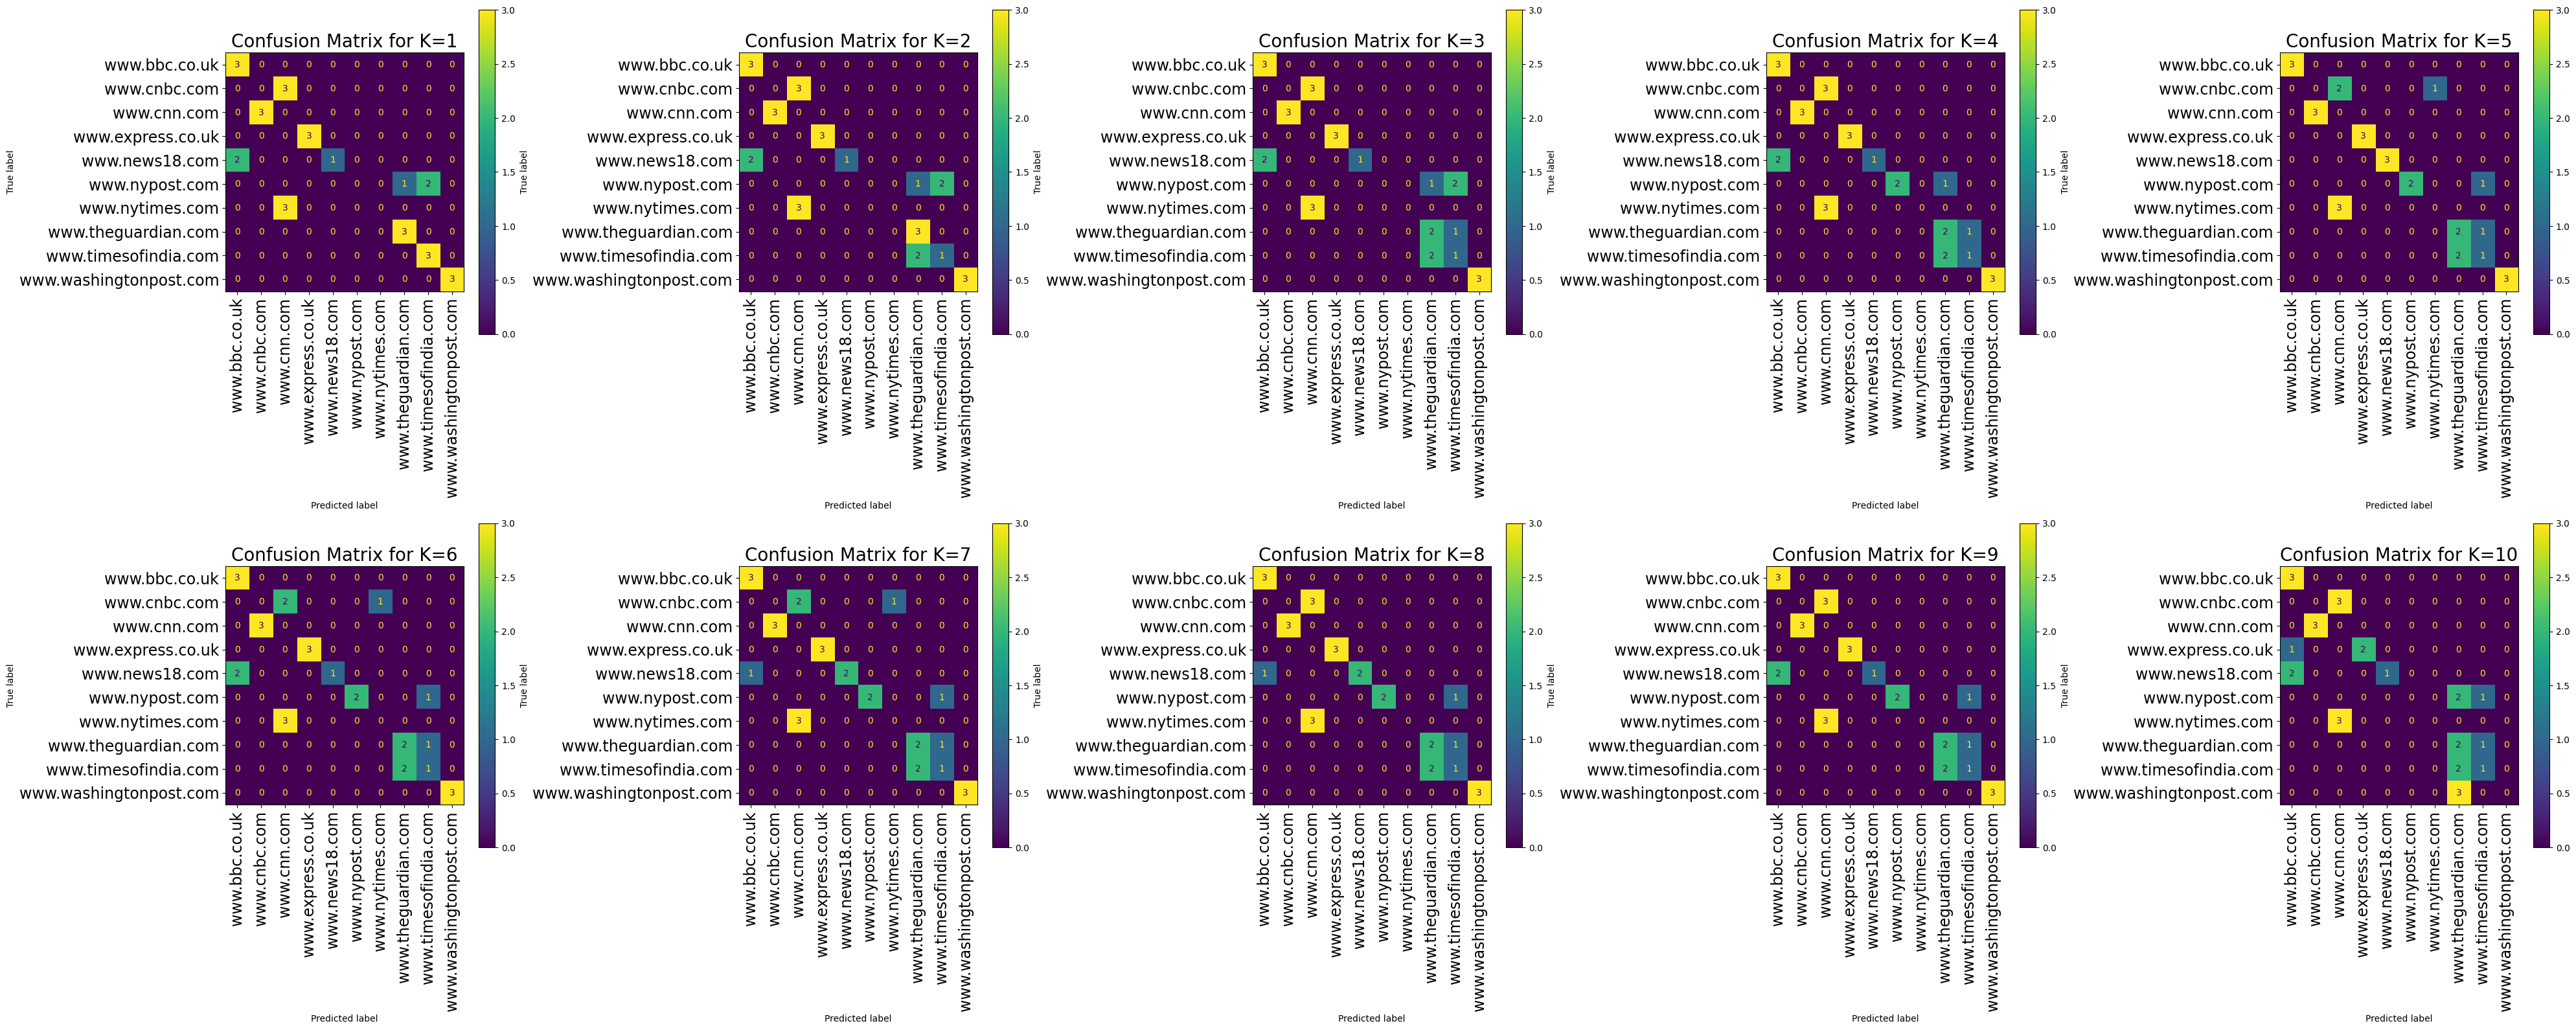

In [176]:
trace_accuracy_list_no_split = make_predictions(x_train,x_test,y_train,y_test,K)

### Evaluate Perfromance with External Test Set

We inspect the accuracy values for K from 1 to 10

In [177]:
for k,accuracy in enumerate(trace_accuracy_list_no_split):
  print(f"Accuracy (K = {k+1}): {accuracy}")

Accuracy (K = 1): 0.5333333333333333
Accuracy (K = 2): 0.4666666666666667
Accuracy (K = 3): 0.43333333333333335
Accuracy (K = 4): 0.5
Accuracy (K = 5): 0.5666666666666667
Accuracy (K = 6): 0.5
Accuracy (K = 7): 0.5333333333333333
Accuracy (K = 8): 0.5333333333333333
Accuracy (K = 9): 0.5
Accuracy (K = 10): 0.3


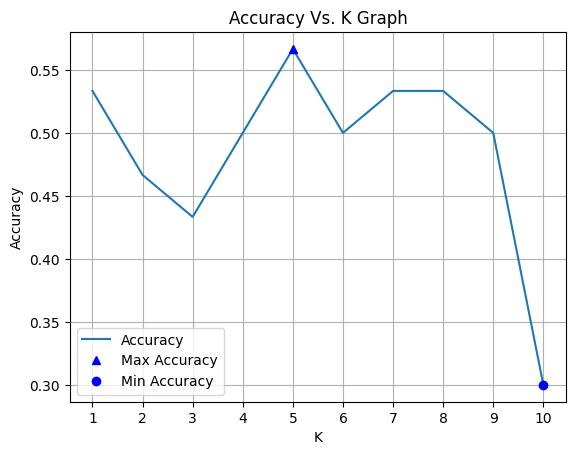

In [178]:
print_accuracy_per_k(trace_accuracy_list_no_split,K)

The Accuracy Vs. K plot shows how the best accuracy is achieved with K = 5, while the worst result is yielded by K = 10.

## Compare Performances

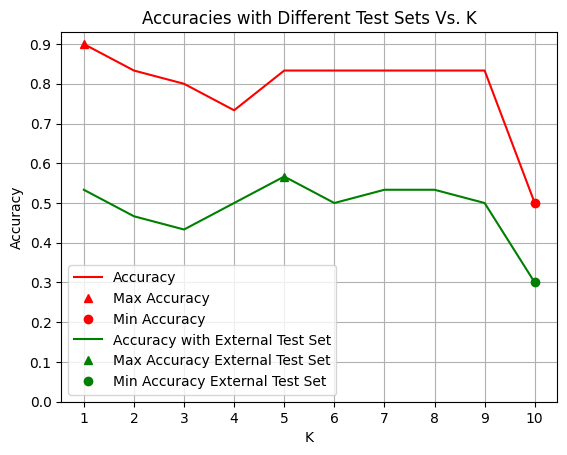

In [179]:
fig = plt.figure()

plt.plot(np.arange(1,K+1,1),trace_accuracy_list,'r')
plt.plot(np.argmax(trace_accuracy_list) + 1, max(trace_accuracy_list), '^r')  # Plot the maximum accuracy point
plt.plot(np.argmin(trace_accuracy_list) + 1, min(trace_accuracy_list), 'or')  # Plot the minimum accuracy point

plt.plot(np.arange(1,K+1,1),trace_accuracy_list_no_split,'g')
plt.plot(np.argmax(trace_accuracy_list_no_split) + 1, max(trace_accuracy_list_no_split), '^g')  # Plot the maximum accuracy point
plt.plot(np.argmin(trace_accuracy_list_no_split) + 1, min(trace_accuracy_list_no_split), 'og')  # Plot the minimum accuracy point

plt.xticks(np.arange(1,K+1,1))
plt.yticks(np.arange(0.0,1.0,0.1))

plt.legend(["Accuracy", "Max Accuracy", "Min Accuracy","Accuracy with External Test Set", "Max Accuracy External Test Set", "Min Accuracy External Test Set"])
plt.title("Accuracies with Different Test Sets Vs. K")
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.grid(True)

The considerations done for the versions of the algorithm using the statisitical biflow features instead of the cumulative trace, like in this case, also hold here.

Indeed, also in this case the accuracy experiences a significant drop-off when switching from a test set captured under the same circumnstances of the training set and a test set collected under different conditions.

Moreover, while in case of a single dataset split between training and test set the best accuracy is that obtained with K = 1, in the version using an external test set the best result is achieved with K = 5. Therefore, also in this case, it is true that more neighbours need to be considered in order to make accurate predictions, when the test data follows a different distribution with respect to training data (green plot). While, in the other scenario (red plot) K = 1 is enough to produce accurate results.

Concerning the worst performance in both versions of the algorithm, we notice how this is mainly due to values of K approaching 10, just like the case with statistical biflow features instead of cumulative traces.


# Conclusion

We can now plot on a single graph the accuracies obtain with the various versions of the algorithm as functions of K.

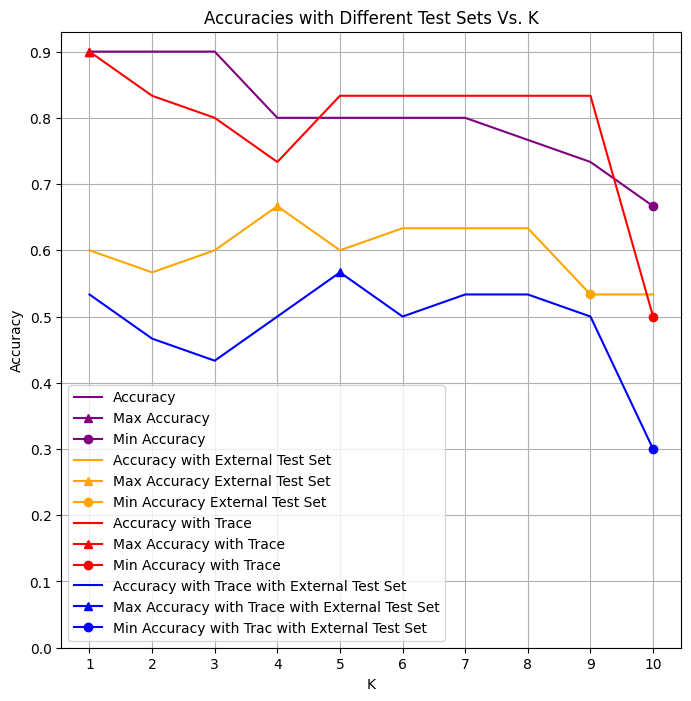

In [180]:
fig = plt.figure(figsize=(8,8))

plt.plot(np.arange(1,K+1,1),accuracy_list,color='purple')
plt.plot(np.argmax(accuracy_list) + 1, max(accuracy_list),color='purple',marker='^')  # Plot the maximum accuracy point
plt.plot(np.argmin(accuracy_list) + 1, min(accuracy_list),color='purple',marker='o')  # Plot the minimum accuracy point

plt.plot(np.arange(1,K+1,1),accuracy_list_no_split,color='orange')
plt.plot(np.argmax(accuracy_list_no_split) + 1, max(accuracy_list_no_split), color='orange',marker='^')  # Plot the maximum accuracy point
plt.plot(np.argmin(accuracy_list_no_split) + 1, min(accuracy_list_no_split),color='orange',marker='o')  # Plot the minimum accuracy point

plt.plot(np.arange(1,K+1,1),trace_accuracy_list,color='red')
plt.plot(np.argmax(trace_accuracy_list) + 1, max(trace_accuracy_list), color='red',marker='^')  # Plot the maximum accuracy point
plt.plot(np.argmin(trace_accuracy_list) + 1, min(trace_accuracy_list), color='red',marker='o')  # Plot the minimum accuracy point

plt.plot(np.arange(1,K+1,1),trace_accuracy_list_no_split,color='blue')
plt.plot(np.argmax(trace_accuracy_list_no_split) + 1, max(trace_accuracy_list_no_split), color='blue',marker='^')  # Plot the maximum accuracy point
plt.plot(np.argmin(trace_accuracy_list_no_split) + 1, min(trace_accuracy_list_no_split), color='blue',marker='o')  # Plot the minimum accuracy point

plt.xticks(np.arange(1,K+1,1))
plt.yticks(np.arange(0.0,1.0,0.1))

plt.legend(["Accuracy", "Max Accuracy", "Min Accuracy","Accuracy with External Test Set", "Max Accuracy External Test Set", "Min Accuracy External Test Set",\
            "Accuracy with Trace", "Max Accuracy with Trace", "Min Accuracy with Trace","Accuracy with Trace with External Test Set", "Max Accuracy with Trace with External Test Set", "Min Accuracy with Trac with External Test Set"])
plt.title("Accuracies with Different Test Sets Vs. K")
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.grid(True)

By comparing all the 4 approaches used to perform website fingerprinting, it emerges that in the ideal scenario in which, independently from the features used in the classification algorithm, train and test set follow the same distribution, the overall accuracy is higher. However none of the 2 solutions (with statstical features - purple plot, or using the cumulative trace - red plot) completely dominates the other. More in detail, the red and pruple plots reach the same maximum point with K = 1 and the purple version dominates the red, unless for the K = [5,9] range. Both graphs, then, reach their minmum point for K = 10. As a result, we have no evidance to say that one version of the algorithm is better than the other, as it depends on some factors, including the parameter K.

Concerning the comparison between the accuracy achieved using different feature selection algorithms, when the test set adopted follows a different distribution with respect to the training data, we could say that using statistical biflow features in this case leads to a better performance. Indeed, the orange graph completely dominates the blue one, for every value of K. However one may argue that we cannot take it as a general rule, because the overall performance depends on many factors. For example, in our case the cumulative trace was sampled at 20 equidistant points, but this parameter could be changed in order to the understand how different values impact the overall performance. What we can say with more confidence, instead, is that using a test set collected after some time with respect to the training set consitently determins a drop-off in accuracy. Additionally, uder these circumnstances intermediate values of K (K between 4 and 5) ensure a higher prediction accuracy and values of K approaching 10 lead the worst perfromance.

Regarding the fact that in some cases the accuracy goes under the 0.8 threshold, reaching non-optimal values, this might be explained by the fact that the dataset used has a limited size. Therefore, it might be that by increasing the number captures per website and/or by increasing the number of websites to visit we could have achieve better performances. Moreover, having used a limited amount of data, might have increased the sensitivity to outliers, thus determining non-optimal accuracy levels.

In [181]:
# K vector
k_df = pd.DataFrame([k for k in range(1,K+1)])
# Build the accuracy matrix
accuracy_df = pd.DataFrame([accuracy_list,accuracy_list_no_split,trace_accuracy_list,trace_accuracy_list_no_split])
# Round decimal values
accuracy_df = accuracy_df.round(3)

accuracy_df_transposed = accuracy_df.transpose()
# Concatenate DataFrames
accuracy_df_transposed = pd.concat([k_df, accuracy_df_transposed], axis=1)
# Set the column names
accuracy_df_transposed.columns = ["K","Accuracy","Accuracy Ext Test Set","Trace Accuracy","Trace Accuracy Ext Test Set"]

display(accuracy_df_transposed)

,K,Accuracy,Accuracy Ext Test Set,Trace Accuracy,Trace Accuracy Ext Test Set
0,1,0.900,0.600,0.900,0.533
1,2,0.900,0.567,0.833,0.467
2,3,0.900,0.600,0.800,0.433
3,4,0.800,0.667,0.733,0.500
4,5,0.800,0.600,0.833,0.567
5,6,0.800,0.633,0.833,0.500
6,7,0.800,0.633,0.833,0.533
7,8,0.767,0.633,0.833,0.533
8,9,0.733,0.533,0.833,0.500
9,10,0.667,0.533,0.500,0.300


This DataFrame provides a more complete overview of the accuracy as function K, depending on the algorithm adopted.